## GAMs (Generalized additive Models)

Generalized additive models are class of models which allow flexible non linearities in several variables but keep the additive structure of linear models.

$y_i = \beta_0 + f_1(x_{i1})+f_2(x_{i2})+...+f_p(x_{ip})+\epsilon_i$. Where $f_1$, $f_2$,..,$f_p$ can be non linear functions. In the sheet below we will apply GAMs to Boston housing data set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

In [2]:
#Import boston dataset
from sklearn import datasets

#Load data in a dataframe
boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_boston.drop('target', axis=1), df_boston['target'].values, test_size=0.20, random_state=1)

print(f"Size of test set = {y_test.shape[0]}")
print(f"Size of train set = {y_train.shape[0]}")

Size of test set = 102
Size of train set = 404


In [3]:
#Lets first standardize the X
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

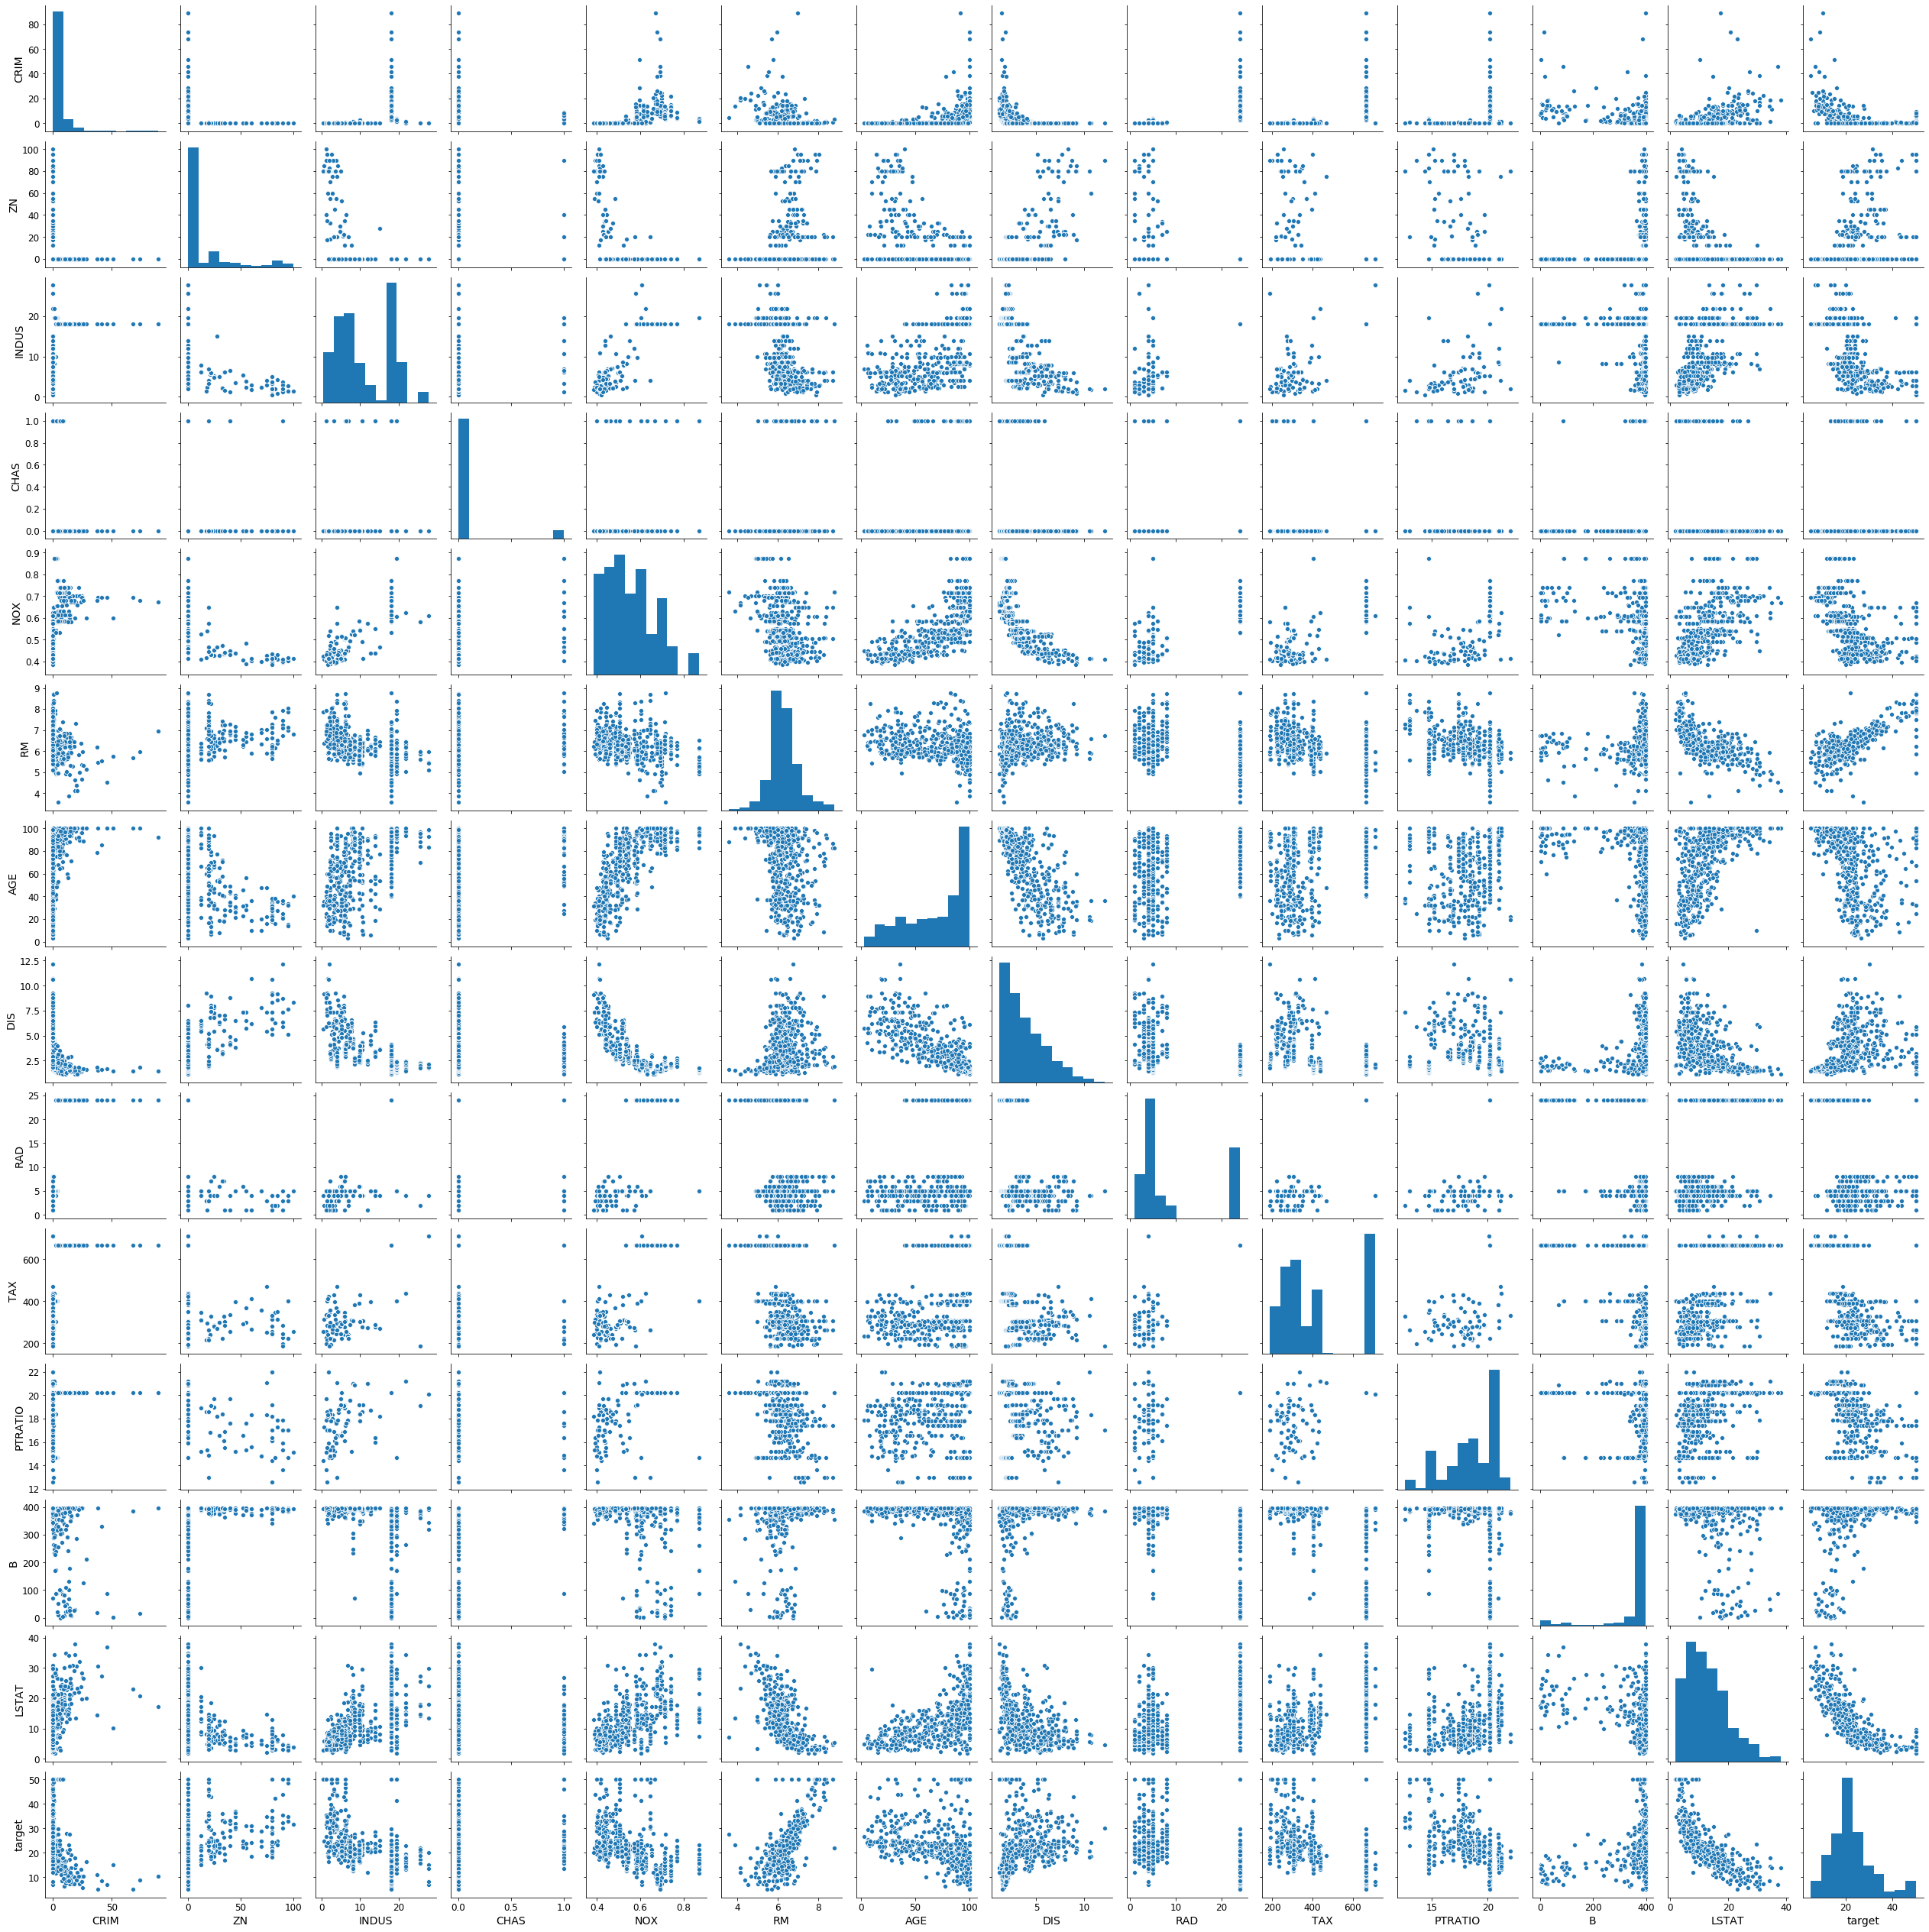

In [4]:
#Lets do basic plotting
import seaborn as sns
sns.pairplot(df_boston)

In [5]:
#Now lets fit a linear model to the data
import statsmodels.api as sm
X_with_intercept = sm.add_constant(X_train_std, prepend=False)
colnames = np.append(boston_data.feature_names, 'intercept')
train_data = pd.DataFrame(X_with_intercept, 
                          columns=colnames)
train_data['target'] =  y_train
mod = sm.OLS(train_data.target,train_data.drop('target', axis=1))
res = mod.fit()
print(res.summary())

X_test_with_intercept = sm.add_constant(X_test_std, prepend=False)
y_test_pred = res.predict(X_test_with_intercept)
y_mean = np.mean(y_test)
TSS = np.sum(np.square(y_test - y_mean))
RSS = np.sum(np.square(y_test - y_test_pred))
score = (1 - RSS/TSS)
print(f"Test set score { score :.3}")

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     80.85
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          5.53e-102
Time:                        23:47:06   Log-Likelihood:                -1196.4
No. Observations:                 404   AIC:                             2421.
Df Residuals:                     390   BIC:                             2477.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -1.0267      0.312     -3.288      0.0

In [25]:
#Now lets fit a GAM to the data
from pygam import LinearGAM, s, f, l
#Lets apply spline functions on feature 4, 7 and 12
np.random.seed(1)
lams = np.random.rand(100, 13) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

random_gam =  LinearGAM(l(0) 
                        + l(1) 
                        + l(2)
                        + f(3) 
                        + s(4)
                        + l(5)
                        + l(6)
                        + s(7)
                        + l(8)
                        + l(9)
                        + l(10)
                        + l(11)
                        + s(12) , fit_intercept=True).gridsearch(X_train_std, y_train, lam=lams)
random_gam.summary()

y_train_pred = random_gam.predict(X_train_std)

100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.7691
Link Function:                     IdentityLink Log Likelihood:                                 -1434.4743
Number of Samples:                          404 AIC:                                             2954.4866
                                                AICc:                                            2964.8798
                                                GCV:                                                16.477
                                                Scale:                                             13.4421
                                                Pseudo R-Squared:                                   0.8508
Feature Function                  Lam

/Users/manan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [26]:
from sklearn.metrics import r2_score
print(f"Train score = {r2_score(y_train, y_train_pred):.3}")
y_test_pred = random_gam.predict(X_test_std)
print(f"Train score = {r2_score(y_test, y_test_pred):.3}")

Train score = 0.851
Train score = 0.886


We got a test score of 88.6%. That is significantly higher than what we get by just simple linear regression.